# Attempting copper classification steps using contrastive learning
Split into down, no change, and up reg in copper condition


In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tqdm

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from Bio.Seq import reverse_complement

# import EarlyStopping
from pytorchtools import EarlyStopping


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
set_seed(7)

Random seed set as 7


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G data

In [4]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')
XYdf_og

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237


In [5]:
loc2seq = dict([(x,z) for (x,z) in XYdf_og[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


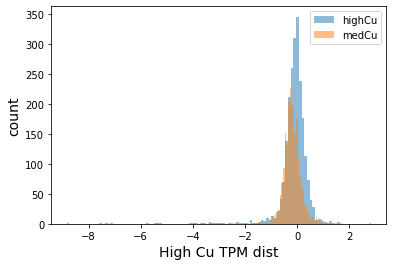

In [6]:
plt.hist(XYdf_og['highCu'].values,bins=100,label="highCu",alpha=0.5)
plt.hist(XYdf_og['medCu'].values,bins=100,label="medCu",alpha=0.5)

plt.legend()
plt.xlabel("High Cu TPM dist",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### How many genes never change?

In [7]:
with open("data/conditions_to_include.txt",'r') as f:
    conds = [x.strip() for x in f.readlines()]
    
conds

['uMax',
 'lowO2_fast_growth',
 'lowCH4',
 'MeOH',
 'NoCu',
 'medCu',
 'highCu',
 'lowCu',
 'highO2_slow_growth',
 'NO3_lowO2_slow_growth',
 'WithLanthanum',
 'NoLanthanum']

In [8]:
data_filename = "data/XY_TPM_opFilt.tsv"
tpm_df = pd.read_csv(data_filename,sep='\t')
tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,52.045884,35.736190,30.829331,23.333155,44.348687,44.920897,47.861477,42.973556,64.784508,32.050358,35.462185,33.444023
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,59.991257,43.159066,33.532522,18.915775,59.629360,65.011074,79.109490,61.209155,99.002970,43.656760,41.792237,43.689839
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,33.943076,27.325800,18.491160,18.453916,28.268717,29.419165,33.534043,28.828713,44.856281,21.351623,20.644554,23.172675
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,48.648085,33.463183,31.643505,16.960643,49.839406,48.729958,48.662214,50.966799,77.842263,41.684925,34.258335,42.367072
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,27.213395,27.232565,12.892833,10.720823,27.164218,25.769601,29.013530,25.968531,19.520794,23.027211,32.713854,34.374071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,8591.278232,9584.028559,7477.339715,1298.257682,8345.785345,5934.168113,8132.547467,7157.344557,3468.582202,6497.868109,3942.957792,5085.637409
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,43.551349,26.951394,18.356915,15.624619,43.065124,43.954096,48.894308,43.386082,40.548782,26.273485,15.972203,16.423284
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,46.058548,31.889009,20.231568,26.004364,44.419579,34.993692,46.109300,36.872718,37.139500,23.525245,49.216725,44.623117
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,31.182164,23.882390,19.721043,20.960234,34.601933,32.907138,30.125207,31.899782,38.204218,26.432667,40.000662,43.201743


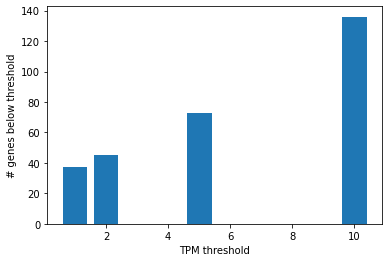

In [9]:
no_tx_genes1 = []
no_tx_genes2 = []
no_tx_genes5 = []
no_tx_genes10 = []
for i, row, in tpm_df.iterrows():
    tpms = row[conds].values
    if max(tpms) < 1.0:
        no_tx_genes1.append(row['locus_tag'])
    if max(tpms) < 2.0:
        no_tx_genes2.append(row['locus_tag'])
    if max(tpms) < 5.0:
        no_tx_genes5.append(row['locus_tag'])
    if max(tpms) < 10.0:
        no_tx_genes10.append(row['locus_tag'])

plt.bar([1,2,5,10],[len(no_tx_genes1),len(no_tx_genes2),len(no_tx_genes5),len(no_tx_genes10)])
plt.xlabel("TPM threshold")
plt.ylabel("# genes below threshold")
plt.show()

In [10]:
len(no_tx_genes10)

136

In [11]:
# do any of these show up in the log ratio up/down?
XYdf_og[XYdf_og['locus_tag'].isin(no_tx_genes2)].sort_values('highCu')[['locus_tag','highCu']]

,locus_tag,highCu
1165,EQU24_RS11910,-1.958143
118,EQU24_RS01215,-0.923850
17,EQU24_RS00205,-0.624566
1943,EQU24_RS19655,-0.624566
783,EQU24_RS07995,-0.170096
1178,EQU24_RS12090,0.000000
1243,EQU24_RS12810,0.000000
1584,EQU24_RS16040,0.000000
1669,EQU24_RS16985,0.000000
1745,EQU24_RS17885,0.000000


In [12]:
# filter out genes that never express above 2 tpms in any condition tested
XYdf = XYdf_og[~XYdf_og['locus_tag'].isin(no_tx_genes2)].reset_index().drop('index',axis=1)
XYdf['product'] = XYdf['locus_tag'].apply(lambda x: locus2info[x]['product'])

In [13]:
XYdf.head()

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,product
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143,chromosomal replication initiator protein DnaA
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725,DNA polymerase III subunit beta
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782,DNA replication/repair protein RecF
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343,hypothetical protein
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613,bifunctional diguanylate cyclase/phosphodieste...


## Add regulatory class to XYdf

In [14]:
def set_reg_class_up_down(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 2
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 2
        else:
            return 1
    
    reg_col = f"{col}_reg_UD"
    df[reg_col] = df[col].apply(lambda x: get_class(x))
    
def set_reg_class_yes_no(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 0
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 0
        else:
            return 1
    
    reg_col = f"{col}_reg_YN"
    df[reg_col] = df[col].apply(lambda x: get_class(x))

In [15]:
set_reg_class_up_down(XYdf,'highCu',thresh=0.6)
set_reg_class_yes_no(XYdf,'highCu',thresh=0.6)
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,product,highCu_reg_UD,highCu_reg_YN
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143,chromosomal replication initiator protein DnaA,1,1
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725,DNA polymerase III subunit beta,1,1
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782,DNA replication/repair protein RecF,1,1
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343,hypothetical protein,1,1
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613,bifunctional diguanylate cyclase/phosphodieste...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619,hypothetical protein,1,1
2155,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777,type II toxin-antitoxin system HicA family toxin,1,1
2156,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596,DUF4102 domain-containing protein,1,1
2157,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237,NaN,1,1


In [16]:
XYdf['highCu_reg_UD'].value_counts()

1    1956
0     145
2      58
Name: highCu_reg_UD, dtype: int64

In [17]:
XYdf['highCu_reg_YN'].value_counts()

1    1956
0     203
Name: highCu_reg_YN, dtype: int64

In [18]:
XYdf[XYdf['highCu_reg_UD']==2].sort_values('highCu')[['locus_tag','product','highCu','highCu_reg_UD','highCu_reg_YN']]

,locus_tag,product,highCu,highCu_reg_UD,highCu_reg_YN
2003,EQU24_RS20690,DEAD/DEAH box helicase,0.601137,2,0
440,EQU24_RS04625,aminotransferase class V-fold PLP-dependent en...,0.605933,2,0
1177,EQU24_RS12320,NADPH-dependent 7-cyano-7-deazaguanine reducta...,0.608029,2,0
1570,EQU24_RS16200,EAL domain-containing protein,0.608627,2,0
1035,EQU24_RS10820,efflux RND transporter periplasmic adaptor sub...,0.610098,2,0
2027,EQU24_RS20860,ribonucleotide reductase,0.613476,2,0
808,EQU24_RS08410,response regulator,0.615717,2,0
1573,EQU24_RS16225,circularly permuted type 2 ATP-grasp protein,0.616791,2,0
1139,EQU24_RS11890,hypothetical protein,0.629000,2,0
962,EQU24_RS09990,30S ribosomal protein S6,0.632446,2,0


In [19]:
XYdf[XYdf['highCu_reg_UD']==0].sort_values('highCu')[['locus_tag','product','highCu','highCu_reg_UD','highCu_reg_YN']]

,locus_tag,product,highCu,highCu_reg_UD,highCu_reg_YN
576,EQU24_RS05885,methane monooxygenase,-8.844506,0,0
577,EQU24_RS05905,soluble methane monooxygenase-binding protein ...,-7.574592,0,0
579,EQU24_RS05920,hypothetical protein,-7.357154,0,0
578,EQU24_RS05915,BLUF domain-containing protein,-7.275122,0,0
580,EQU24_RS05925,likely chaperone for smmo,-7.104795,0,0
...,...,...,...,...,...
1492,EQU24_RS15440,hypothetical protein,-0.606958,0,0
11,EQU24_RS00165,hypothetical protein,-0.604148,0,0
1081,EQU24_RS11350,hypothetical protein,-0.603603,0,0
519,EQU24_RS05405,ShlB/FhaC/HecB family hemolysin secretion/acti...,-0.603308,0,0


In [20]:
XYdf[XYdf['locus_tag'].isin(['EQU24_RS19315','EQU24_RS19520'])]

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,product,highCu_reg_UD,highCu_reg_YN
1867,3671,EQU24_RS19315,ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAAT...,0.954381,1.313821,1.459975,-0.526926,0.0,0.600282,0.909567,0.389121,0.351281,1.326338,1.172579,1.305701,methane monooxygenase/ammonia monooxygenase su...,2,0
1890,3712,EQU24_RS19520,CACACAGTTTAGGTGTGTGATATCACGCAGTCCCATACTTCATTTT...,-8.803976,-7.623770,-10.717938,-4.722293,0.0,-0.795353,-5.383131,-0.167760,-9.205036,-3.036988,-10.929817,-10.956223,type II secretion system protein,0,0


### Train/val/test splitting

In [21]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
def plot_train_test_stacks(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores in categories, sanity check that its not skewed'''
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    temp_df = pd.concat([train_df,test_df])
    if val_df is not None:
        val_df['set'] = 'val'
        temp_df = pd.concat([temp_df,val_df])
        
    temp_df = temp_df.value_counts([score_col,'set']).to_frame('count').reset_index()
        
    #temp_df = pd.melt(temp_df[['locus_tag',score_col,'set']],id_vars['locus_tag'])
    sns.barplot(x=score_col, y = 'count', data = temp_df, hue = "set")
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()
    

def see_batch_class_dist(train_dl,classes=[0,1,2]):
    '''Check distribution of classes in each batch'''
    
    data = []
    for i,(xb, yb) in enumerate(train_dl):
        vals, counts = yb.unique(return_counts=True)
        z=dict(list(zip(np.array(vals),np.array(counts))))
        row = []
        for cls in classes:
            if cls in z:
                data.append((i,cls,z[cls]))
            else:
                print(f"WARNING: no instance of class {cls} in batch {i}")
                data.append((i,cls,0))

    batch_dist = pd.DataFrame(data, columns=['batch','class','count'])
    sns.barplot(x='batch', y = 'count', data = batch_dist, hue = "class")
    plt.show()


### Use a shuffle stratified split 
Make sure at least some of the minority classes make it into the test/val sets

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

# define single splitter
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=0)

# use to split full train and test
sp1 = sss.split(XYdf['upstream_region'].values, XYdf['highCu_reg_UD'].values)
# extract from the generator
full_train_idx,test_idx = [(a,b) for a,b in sp1][0]

# retrieve full_train and test dfs
full_train_df = XYdf.iloc[full_train_idx]
test_df = XYdf.iloc[test_idx]

# now split the full train into train and val
sp2 = sss.split(full_train_df['upstream_region'].values, full_train_df['highCu_reg_UD'].values)
# extract from the generator
train_idx,val_idx = [(a,b) for a,b in sp2][0]

# retrieve train and val dfs
train_df = full_train_df.iloc[train_idx]
val_df = full_train_df.iloc[val_idx]

In [23]:
print("Full Train")
display(full_train_df['highCu_reg_UD'].value_counts())
print("Test")
display(test_df['highCu_reg_UD'].value_counts())
print("Train")
display(train_df['highCu_reg_UD'].value_counts())
print("Val")
display(val_df['highCu_reg_UD'].value_counts())

Full Train


1    1565
0     116
2      46
Name: highCu_reg_UD, dtype: int64

Test


1    391
0     29
2     12
Name: highCu_reg_UD, dtype: int64

Train


1    1251
0      93
2      37
Name: highCu_reg_UD, dtype: int64

Val


1    314
0     23
2      9
Name: highCu_reg_UD, dtype: int64

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

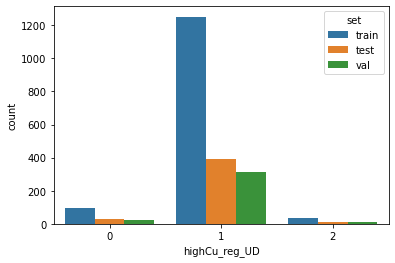

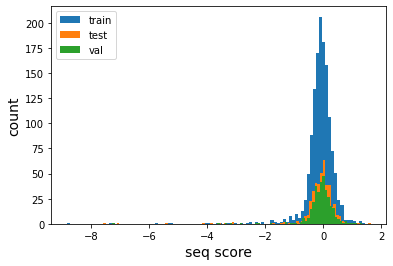

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

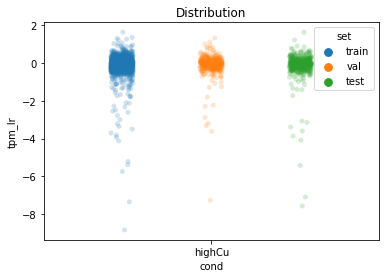

In [24]:
#plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='highCu_reg_YN')
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='highCu_reg_UD')
plot_train_test_hist(train_df, test_df,val_df=val_df,score_col='highCu',bins=100)
view_train_test_dist(train_df, test_df,["highCu"],val_df=val_df,id_col='locus_tag')


## Load 5G seqs into data loaders

In [25]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [26]:
# full_train_df,test_df = tu.quick_split(XYdf)
# train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu_reg_UD',
    sampler=None,
    batch_size=256
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

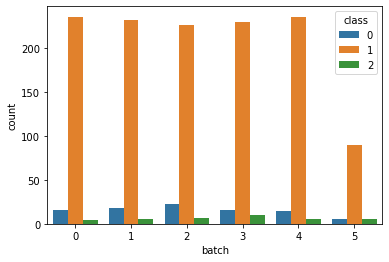

In [27]:
see_batch_class_dist(ohe_train_dl)

## Fitting loop functions

In [ ]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    #loss = loss_func(xb_out, yb.float())
    loss = loss_func(xb_out, yb.long().squeeze(1))
    # ^^ changes for CrossEntropyLoss...

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        #print("train loss batch:",t)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl,patience=5000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # create early stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=False)
    
    # loops through epochs
    #for epoch in range(epochs): #tqdm?
    with tqdm.trange(epochs) as pbar:
        for i in pbar:
            
    
            train_loss = train_step(model, train_dl, loss_func, opt)
            train_losses.append(train_loss)


            val_loss = val_step(model, val_dl, loss_func)
            #print(epoch, val_loss)
            val_losses.append(val_loss)
            
            pbar.set_description(f"E:{i} | train loss:{train_loss:.3f} | val loss: {val_loss:.3f}")
            
            # copied from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(val_loss, model,i)

            if early_stopping.early_stop:
                print("Early stopping")
                break
    
    # Epoch and value of best model checkpoint
    estop = early_stopping.best_model_epoch
    best_val_score = early_stopping.val_loss_min 

    # load the last checkpoint with the best model
    #model.load_state_dict(torch.load('checkpoint.pt'))
    # ^^ Does this need to be returned? I dont' think so... loads in place

    return train_losses, val_losses,estop,best_val_score

def run_model(train_dl,test_dl, model, loss_func,opt=None, lr=0.01, epochs=20,reload=False):
    '''
    Given data and a model type, run dataloaders with SGD opt
    '''
    # define loss func and optimizer
    if opt:
        optimizer = opt
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, \
    test_losses,\
    epoch_stop,\
    best_val_score = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    if reload:
        model.load_state_dict(torch.load('checkpoint.pt'))
        print(f"Reloaded state dict from best epoch {epoch_stop}")
    
    #return model, train_losses, test_losses
    return train_losses, test_losses,epoch_stop,best_val_score

In [29]:
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 3), # 3 for 3 classes
            #nn.Softmax(dim=1)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            #nn.Softmax(dim=1)
            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

# class Kmer_Linear(nn.Module):
#     def __init__(self,num_kmers,h1_size,h2_size):
#         super().__init__()
        
#         # some arbitrary arch of a few linear layers
#         self.lin = nn.Sequential(
#             nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
#             nn.ReLU(inplace=True),
#             nn.Linear(h1_size, h2_size),
#             nn.ReLU(inplace=True),
#             nn.Linear(h2_size, 1),
#         )
        
        
#     def forward(self, xb):
#         out = self.lin(xb)
#         #print("Lin out shape:", out.shape)
#         return out

In [30]:
def plot_confusion(models,genes,oracle,objs):
    '''Get class predictions and plot confusion matrix'''
    dfs = {}
    for model_name,model,ds in models:
        model.eval()
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.topk(1) for x in model(s.float())]
            
            for i in range(len(preds)):
                prob,cls = [x.item() for x in preds[i]]
                data.append((gene,actual[i], cls,prob,objs[i],dna))
                
        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','task','seq'])
        c = confusion_matrix(df['truth'].values, df['pred'].values)
        disp = ConfusionMatrixDisplay(confusion_matrix=c)
        disp.plot()
        plt.title(f"{model_name} confusion matrix")
        plt.show()

        dfs[model_name] = (c,df)
        
    return dfs

### Deep linear

In [31]:
seq_len = len(train_df['upstream_region'].values[0])
seq_len

300

E:1433 | train loss:0.002 | val loss: 0.990:  48%|████▊     | 1431/3000 [00:37<00:39, 39.82it/s]

EarlyStopping counter: 1250 out of 5000


E:2683 | train loss:0.001 | val loss: 1.130:  89%|████████▉ | 2682/3000 [01:09<00:07, 41.07it/s]

EarlyStopping counter: 2500 out of 5000


E:2999 | train loss:0.000 | val loss: 1.152: 100%|██████████| 3000/3000 [01:17<00:00, 38.87it/s]


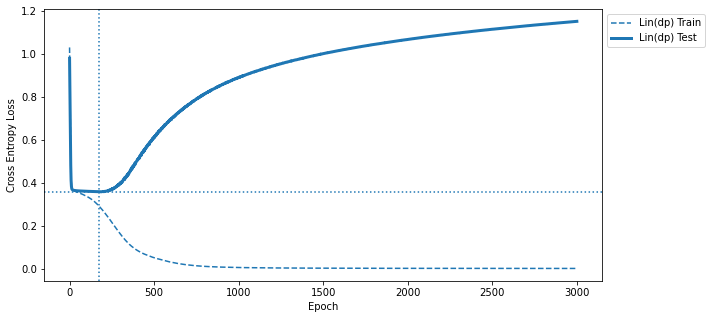

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [32]:
mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
mer8motif_model_lin_d.to(DEVICE)


#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label = 'Cross Entropy Loss'
mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d,estop,best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    loss_func,
    lr=0.01,
    epochs=3000
)

# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)",estop,best_val)]
tu.quick_loss_plot(mer8motif_lin_d_data_label,loss_type=loss_label)

mer8motif_model_lin_d

Running LinearDeep


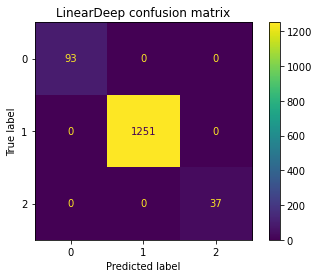

Running LinearDeep


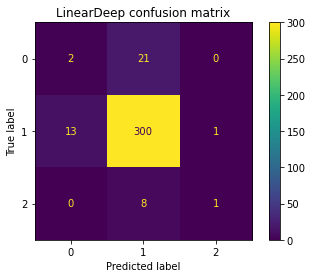

In [33]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
]


train_seqs =  train_df['locus_tag'].values 
val_seqs =  val_df['locus_tag'].values 
task = "CU_UD"

oracle = dict([(a,[b]) for a,b in XYdf[['locus_tag','highCu_reg_UD']].values])


dfs_train = plot_confusion(models, train_seqs, oracle,[task])
dfs_val = plot_confusion(models, val_seqs, oracle,[task])

In [34]:
def calc_loss_post_training(model, df,loss_func,loc_col='locus_tag',target_col='score'):
    '''
    Quick function to manually check loss calculation on set of seqs
    '''
    
    # put seqs in proper X format
    loci = df[loc_col].values
    ohe_seqs = [u.one_hot_encode(loc2seq[x]) for x in loci]
    seq_tensors = [torch.tensor(x).unsqueeze(0).to(DEVICE) for x in ohe_seqs]
    
    X = torch.stack(seq_tensors).float()
    
    # put labels in proper y format
    labels = list(df[target_col].values)
    y = torch.tensor(labels).long().to(DEVICE)

    # get predictions
    preds = model(X)
    
    # calc loss
    loss = loss_func(preds, y)
    print(loss)
    
    


In [35]:
calc_loss_post_training(
    mer8motif_model_lin_d,
    test_df,
    nn.CrossEntropyLoss(),
    target_col="highCu_reg_UD"
)

tensor(1.5182, device='cuda:0', grad_fn=<NllLossBackward>)


### CNN model

In [36]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 10,
                 fc_node_num1 = 10,
                 dropout1 = 0.2,
                 dropout2 = 0.2,
                ):
        super().__init__()
        
        self.seq_len = seq_len
        
        # calculation for number of linear nodes need to come after final conv layer
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1
        #linear_node_num = linear_node_num*num_filters0
        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.MaxPool2d((1,conv_pool_size0)), # def stride = kernel_size
            nn.Dropout(dropout1),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            nn.Dropout(dropout1),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            
            # Fully connected layer 1
            nn.Linear(fc_node_num0, fc_node_num1),
            nn.ReLU(),
            
            # final prediction
            nn.Linear(fc_node_num1, 3),
            #nn.Softmax(dim=1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

E:1983 | train loss:0.030 | val loss: 0.805:  66%|██████▌   | 1984/3000 [02:51<01:27, 11.64it/s]

EarlyStopping counter: 1250 out of 5000


E:2999 | train loss:0.007 | val loss: 0.965: 100%|██████████| 3000/3000 [04:18<00:00, 11.61it/s]


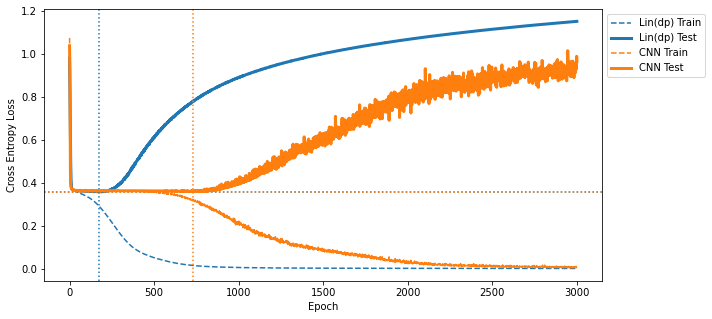

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=2880, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [37]:
# make model
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,10.0,10.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"
# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn,\
estop,\
best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=3000,
)

# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN',estop,best_val)]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label,loss_type=loss_label)

mer8motif_model_cnn

In [38]:
#tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label,sparse_n=20)


Running LinearDeep


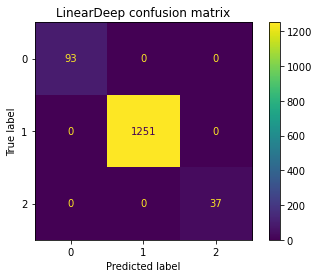

Running CNN


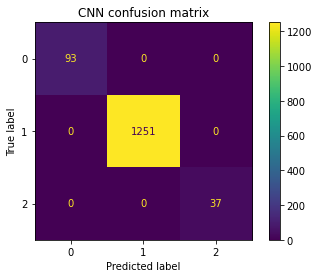

Running LinearDeep


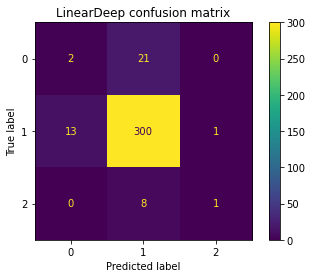

Running CNN


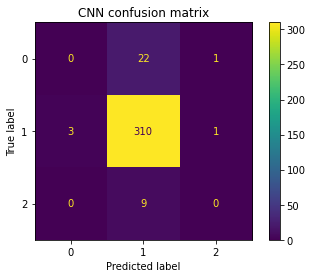

In [39]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


dfs_train = plot_confusion(models, train_seqs, oracle,[task])
dfs_val = plot_confusion(models, val_seqs, oracle,[task])

In [40]:
from sklearn.metrics import classification_report

In [41]:
def print_cls_rep(conf_res):

    trues = conf_res['truth'].values
    preds = conf_res['pred'].values

    print(classification_report(trues, preds))

In [42]:
# probably don't need this... replace with sklearn classification report


# from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,precision_recall_curve,matthews_corrcoef

# def cls_report(df,model_name):
#     '''Basic print out of precicion/recall/f1 scores'''
    
#     acc = accuracy_score(df['truth'].values,df['pred'].values)
#     mcc = matthews_corrcoef(df['truth'].values,df['pred'].values)
#     print(f"{model_name} (acc={acc:.3f} | mcc={mcc:.3f})")
#     for a in ['micro','macro']:#,'weighted']:
#         p = precision_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
#         r = recall_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
#         f1 = f1_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
#         print(f"{a}: p={p:.3f}\t r={r:.3f}\t f1={f1:.3f}")

# def quick_classify(model, seqs,oracle):
#     '''Given some sequences, get the model's predictions '''
#     mis_classified = []
#     for gene in seqs:
#         dna = loc2seq[gene]
#         s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
#         pred = model(s.float())
#         prob,cls = pred.topk(1)
#         actual = oracle[gene][0]
#         correct = (cls.item() == actual)
#         if not correct:
#             #print(f"{gene}: pred:{cls.item()} actual:{actual}")
#             mis_classified.append(gene)
#             print(f"{gene}: pred:{cls.item()} actual:{actual} ({pred.tolist()[0]})")

#     print('done')
#     return mis_classified
        

In [43]:
# lind_res = dfs_val['LinearDeep'][1]
# cnn_res = dfs_val['CNN'][1]

# cls_report(lind_res,"LinearDeep")
# print()
# cls_report(cnn_res,"CNN")

In [44]:
#mis = quick_classify(mer8motif_model_cnn,val_seqs,oracle_syn)

## use weighted loss function

In [45]:
# https://discuss.pytorch.org/t/weights-in-bcewithlogitsloss/27452/11?u=crypdick
def get_loss_weights(ys):
    '''
    Determine loss reweighting vector by the inverse of the positive
    examples for each iMod task
    '''
    total_count = len(ys)
    class_counts = torch.bincount(torch.tensor(ys))
    pos_weights = np.ones_like(class_counts)
    #neg_counts = [len(ys)-pos_count for pos_count in class_counts]  # <-- HERE 
    
    #for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
    for class_idx, pos_count in enumerate(class_counts):
        print(f"{class_idx}| pos:{pos_count}  total:{total_count}")
        value =  total_count / (pos_count + 1e-5)
        print("value:",value)
        pos_weights[class_idx] = value
        

    return torch.as_tensor(pos_weights, dtype=torch.float)

In [46]:
y = XYdf['highCu_reg_UD'].values
get_loss_weights(y)

0| pos:145  total:2159
value: tensor(14.8897)
1| pos:1956  total:2159
value: tensor(1.1038)
2| pos:58  total:2159
value: tensor(37.2241)


tensor([14.,  1., 37.])

In [47]:
print(145*14.8897)
print(1956*1.1038)
print(58*37.2241)

2159.0065
2159.0328
2158.9978


0| pos:145  total:2159
value: tensor(14.8897)
1| pos:1956  total:2159
value: tensor(1.1038)
2| pos:58  total:2159
value: tensor(37.2241)


E:1449 | train loss:0.012 | val loss: 5.482:  29%|██▉       | 1449/5000 [02:06<05:04, 11.67it/s]

EarlyStopping counter: 1250 out of 5000


E:2699 | train loss:0.003 | val loss: 6.571:  54%|█████▍    | 2699/5000 [03:53<03:17, 11.64it/s]

EarlyStopping counter: 2500 out of 5000


E:3949 | train loss:0.004 | val loss: 7.257:  79%|███████▉  | 3949/5000 [05:41<01:30, 11.59it/s]

EarlyStopping counter: 3750 out of 5000


E:4999 | train loss:0.002 | val loss: 7.495: 100%|██████████| 5000/5000 [07:12<00:00, 11.57it/s]


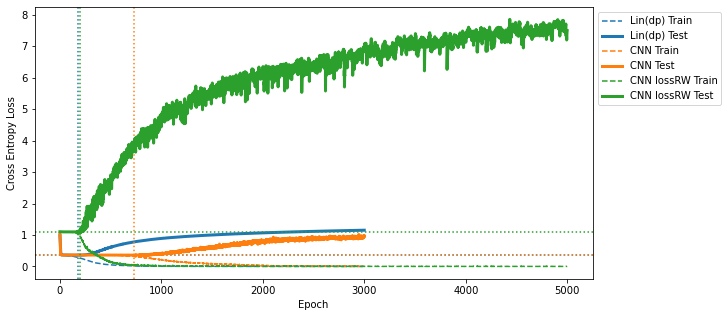

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=2880, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [48]:
# make model
model_cnn_lossrw = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
model_cnn_lossrw.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
w = get_loss_weights(y).to(DEVICE)
loss_func = nn.CrossEntropyLoss(weight=w)
loss_label= "Cross Entropy Loss"
# run model
train_losses_cnn_lossrw, \
val_losses_cnn_lossrw,\
estop,\
best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    model_cnn_lossrw, 
    loss_func,
    lr=0.01,
    epochs=5000,
)

# to plot loss
cnn_lossrw_data_label = [((train_losses_cnn_lossrw,val_losses_cnn_lossrw),'CNN lossRW',estop,best_val)]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label+cnn_lossrw_data_label,loss_type=loss_label)

model_cnn_lossrw

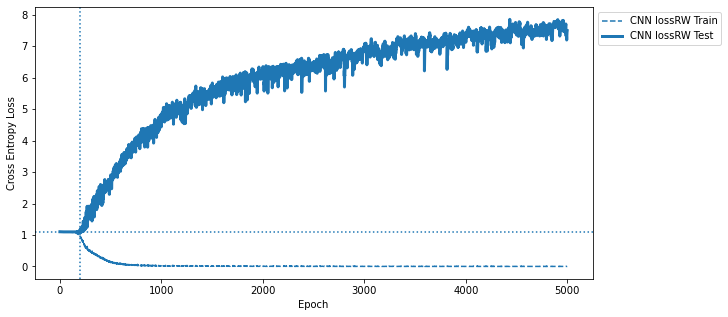

In [49]:
tu.quick_loss_plot(cnn_lossrw_data_label,loss_type=loss_label)


__TRAIN__
Running LinearDeep


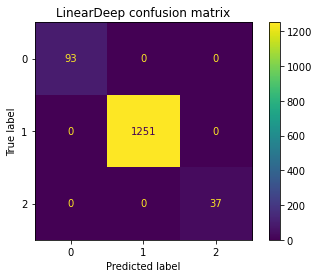

Running CNN


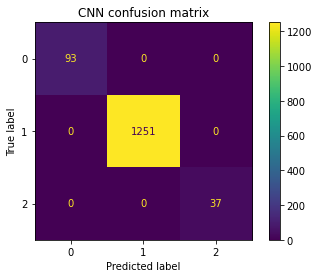

Running CNN LossRW


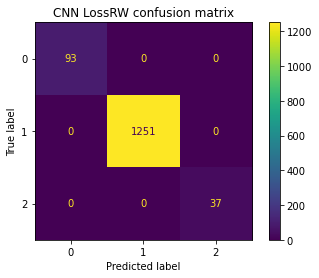

__VAL__
Running LinearDeep


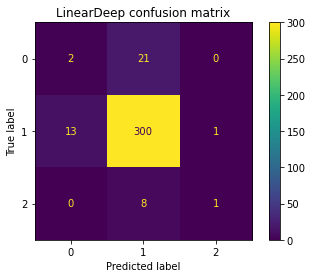

Running CNN


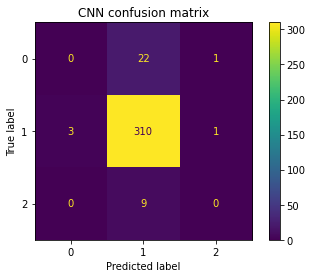

Running CNN LossRW


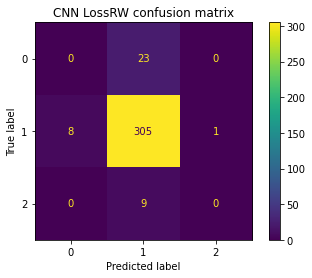

In [50]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
    ("CNN LossRW",model_cnn_lossrw,DatasetSpec('ohe')),
]

print("__TRAIN__")
dfs_train = plot_confusion(models, train_seqs, oracle,[task])
print("__VAL__")
dfs_val = plot_confusion(models, val_seqs, oracle,[task])

In [51]:
#print(classification_report(dfs_train['CNN LossRW'][1]['truth'].values, dfs_train['CNN LossRW'][1]['pred'].values))
conf_res = dfs_val['CNN LossRW'][1]
print_cls_rep(conf_res)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.91      0.97      0.94       314
           2       0.00      0.00      0.00         9

    accuracy                           0.88       346
   macro avg       0.30      0.32      0.31       346
weighted avg       0.82      0.88      0.85       346



## Rebalance sampler

In [52]:
from torch.utils.data.sampler import WeightedRandomSampler


In [53]:
def make_weighted_sampler(df, reg):
    '''
    Given a training dataframe, create a balanced sampler for the class
    indicated
    '''
    # make weighted sampler for data loader
    class_sample_count = df[reg].value_counts()
    # get 1/count as weight for each class
    weight = dict([(x,(1. / class_sample_count[x])) for x in class_sample_count.keys()])
    # apply new weight to each sample
    samples_weight = np.array([weight[t] for t in train_df[reg].values])
    samples_weight = torch.from_numpy(samples_weight).double()

    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [54]:
reg = "highCu_reg_UD"
sampler = make_weighted_sampler(train_df, reg)

In [55]:
# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col=reg,
    sampler=sampler,
    shuffle=False,
    batch_size=256
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [56]:
print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(1727, 18)
(432, 19)
(1381, 19)
(346, 19)


In [57]:
train_df[reg].value_counts()

1    1251
0      93
2      37
Name: highCu_reg_UD, dtype: int64

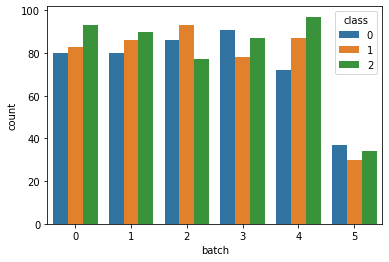

In [58]:
see_batch_class_dist(ohe_train_dl)
# the exact dist changes everytime

### Reweighted Linear Deep

In [59]:
seq_len = len(train_df['upstream_region'].values[0])

E:999 | train loss:0.002 | val loss: 0.844: 100%|██████████| 1000/1000 [00:25<00:00, 39.43it/s]


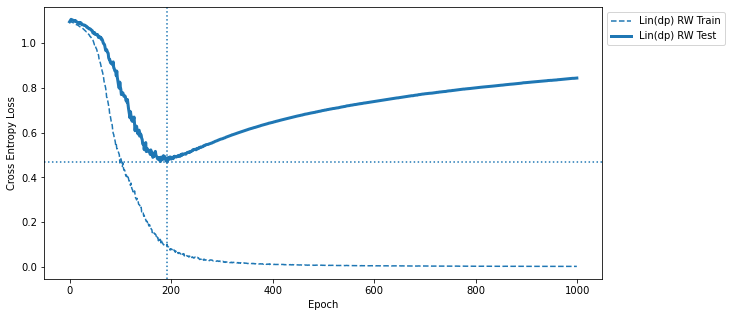

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [60]:
mer8motif_model_lin_d_rw = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
mer8motif_model_lin_d_rw.to(DEVICE)


#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label = 'Cross Entropy Loss'
mer8motif_train_losses_lin_d_rw, \
mer8motif_test_losses_lin_d_rw,\
estop,\
best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d_rw,
    loss_func,
    lr=0.01,
    epochs=1000
)

# to plot loss
mer8motif_lin_d_rw_data_label = [((mer8motif_train_losses_lin_d_rw,mer8motif_test_losses_lin_d_rw),"Lin(dp) RW",estop,best_val)]
tu.quick_loss_plot(mer8motif_lin_d_rw_data_label,loss_type=loss_label)

mer8motif_model_lin_d_rw

E:1655 | train loss:0.011 | val loss: 0.837:  17%|█▋        | 1656/10000 [02:22<11:55, 11.66it/s]

EarlyStopping counter: 1250 out of 5000


E:2905 | train loss:0.006 | val loss: 0.920:  29%|██▉       | 2906/10000 [04:09<10:02, 11.77it/s]

EarlyStopping counter: 2500 out of 5000


E:4154 | train loss:0.001 | val loss: 0.995:  42%|████▏     | 4154/10000 [05:54<08:13, 11.84it/s]

EarlyStopping counter: 3750 out of 5000


E:5403 | train loss:0.001 | val loss: 1.050:  54%|█████▍    | 5403/10000 [07:40<06:31, 11.74it/s]


EarlyStopping counter: 5000 out of 5000
Early stopping


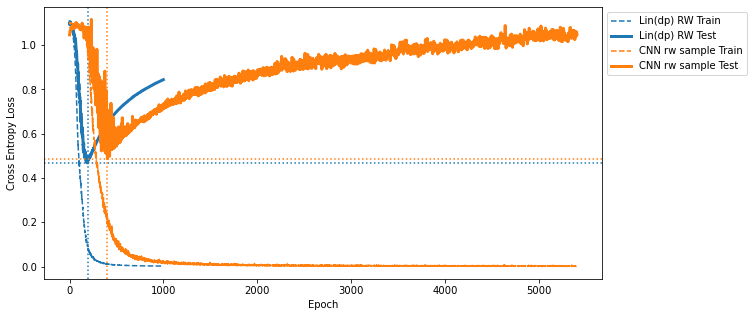

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=2880, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [61]:
# make model

mer8motif_model_cnn_rw = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn_rw.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"

# run model
mer8motif_train_losses_cnn_rw, \
mer8motif_test_losses_cnn_rw,\
estop,\
best_val= run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn_rw, 
    loss_func,
    lr=0.01,
    epochs=10000,
)

mer8motif_cnn_rw_data_label = [((mer8motif_train_losses_cnn_rw,mer8motif_test_losses_cnn_rw),'CNN rw sample',estop,best_val)]

tu.quick_loss_plot(
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label,
    loss_type=loss_label)

mer8motif_model_cnn_rw

In [62]:
print('hi')

hi


__TRAIN__
Running LinearDeep


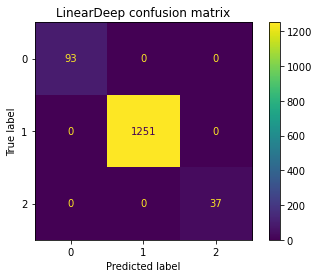

Running CNN


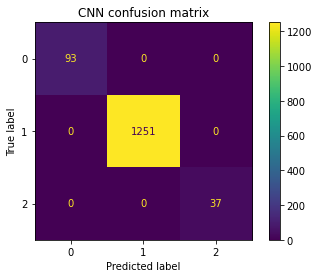

Running CNN LossRW


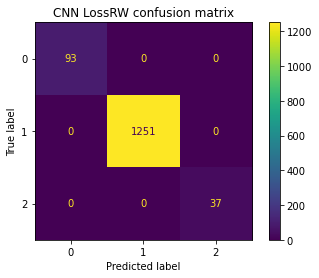

Running LinDeep SampleRW


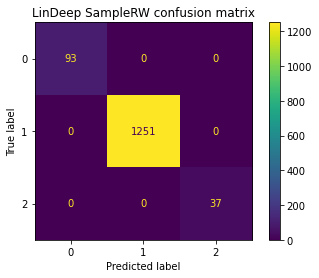

Running CNN SampleRW


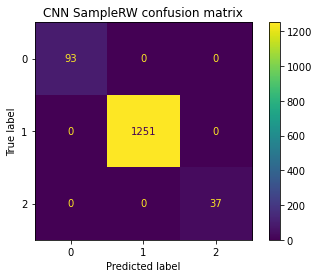

__VAL__
Running LinearDeep


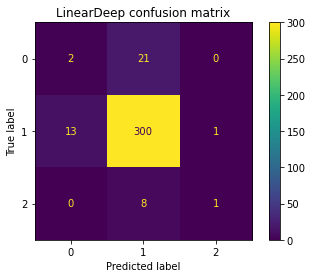

Running CNN


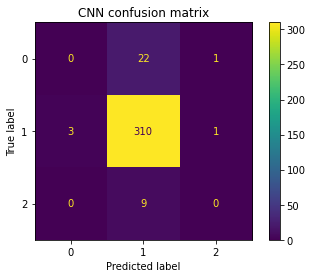

Running CNN LossRW


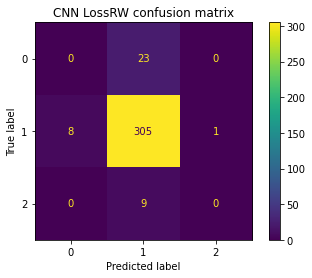

Running LinDeep SampleRW


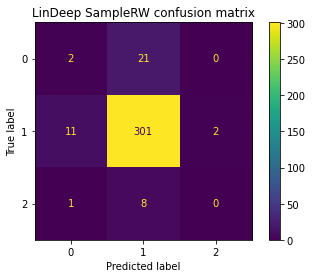

Running CNN SampleRW


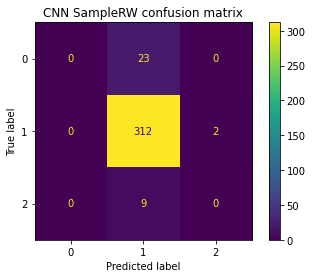

In [63]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
    ("CNN LossRW",model_cnn_lossrw,DatasetSpec('ohe')),
    ("LinDeep SampleRW",mer8motif_model_lin_d_rw,DatasetSpec('ohe')),
    ("CNN SampleRW",mer8motif_model_cnn_rw,DatasetSpec('ohe')),
]

print("__TRAIN__")
dfs_train = plot_confusion(models, train_seqs, oracle,[task])
print("__VAL__")
dfs_val = plot_confusion(models, val_seqs, oracle,[task])

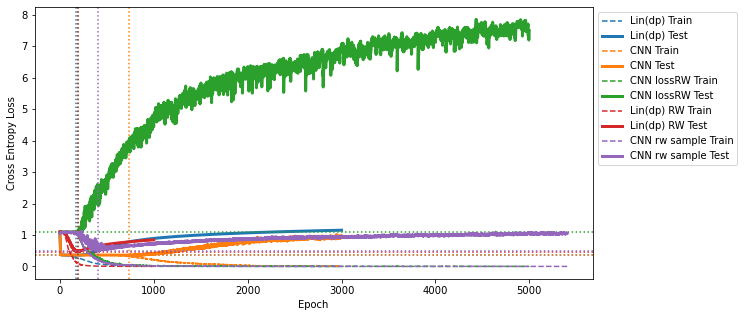

In [64]:
tu.quick_loss_plot(
    mer8motif_lin_d_data_label+\
    mer8motif_cnn_data_label+\
    cnn_lossrw_data_label+\
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label,
    loss_type=loss_label)

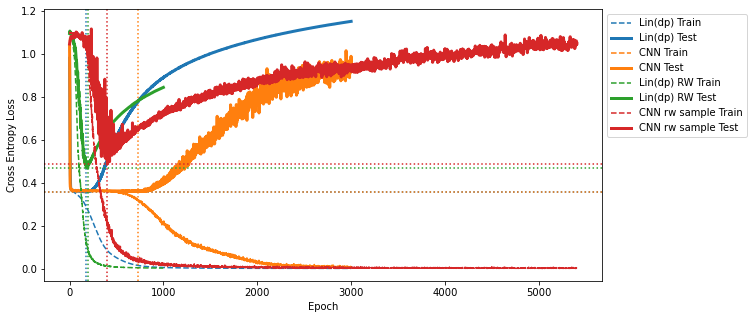

In [68]:
tu.quick_loss_plot(
    mer8motif_lin_d_data_label+\
    mer8motif_cnn_data_label+\
    #cnn_lossrw_data_label+\
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label,
    loss_type=loss_label)

### Slow learning rate 

E:4848 | train loss:0.075 | val loss: 0.582:  48%|████▊     | 4848/10000 [06:44<07:13, 11.90it/s]

EarlyStopping counter: 1250 out of 5000


E:6098 | train loss:0.038 | val loss: 0.636:  61%|██████    | 6098/10000 [08:28<05:13, 12.44it/s]

EarlyStopping counter: 2500 out of 5000


E:7348 | train loss:0.026 | val loss: 0.682:  73%|███████▎  | 7348/10000 [10:12<03:45, 11.74it/s]

EarlyStopping counter: 3750 out of 5000


E:8596 | train loss:0.026 | val loss: 0.719:  86%|████████▌ | 8596/10000 [11:56<01:57, 12.00it/s]


EarlyStopping counter: 5000 out of 5000
Early stopping


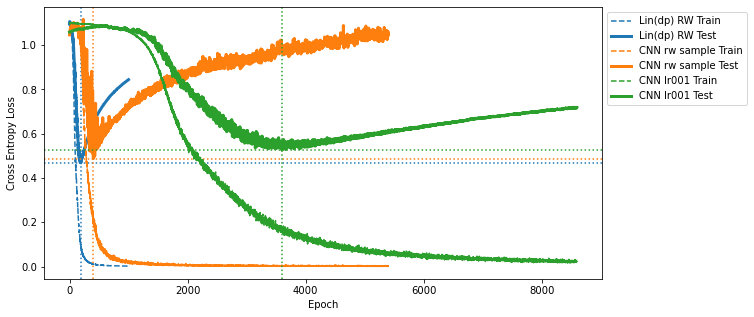

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=2880, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [69]:
# make model
seq_len = len(train_df['upstream_region'].values[0])

lr001_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
lr001_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"

# run model
lr001_train_losses_cnn, \
lr001_test_losses_cnn,\
estop,\
best_val= run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    lr001_cnn, 
    loss_func,
    lr=0.001,
    epochs=10000,
)

lr001_cnn_data_label = [((lr001_train_losses_cnn,lr001_test_losses_cnn),'CNN lr001',estop,best_val)]

tu.quick_loss_plot(
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label,
    loss_type=loss_label
    #sparse_n=20
)

lr001_cnn

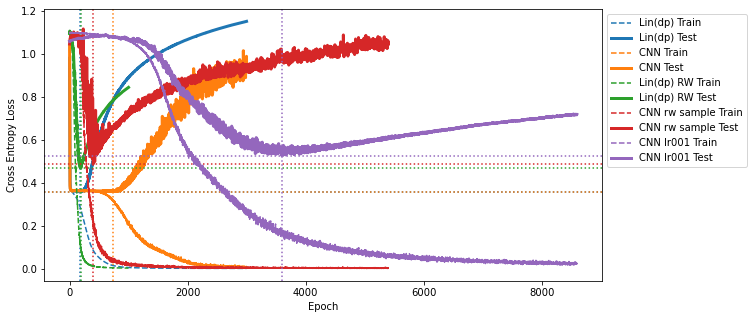

In [70]:
tu.quick_loss_plot(
    mer8motif_lin_d_data_label+\
    mer8motif_cnn_data_label+\
    #cnn_lossrw_data_label+\
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label,
    loss_type=loss_label)

### Adam optimizer and slow lr?

In [ ]:
lr001_adam_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
lr001_adam_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"

# run model
lr001_adam_train_losses_cnn, \
lr001_adam_test_losses_cnn,\
estop,\
best_val= run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    lr001_adam_cnn, 
    loss_func,
    lr=0.001,
    epochs=10000,
)

lr001_adam_cnn_data_label = [((lr001_adam_train_losses_cnn,lr001_adam_test_losses_cnn),'CNN lr001 Adam',estop,best_val)]

tu.quick_loss_plot(
    mer8motif_lin_d_data_label+\
    mer8motif_cnn_data_label+\
    #cnn_lossrw_data_label+\
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label+\
    lr001_adam_cnn_data_label,
    loss_type=loss_label
    #sparse_n=20
)

lr001_adam_cnn

E:2899 | train loss:1.086 | val loss: 1.099:  29%|██▉       | 2900/10000 [04:01<09:37, 12.30it/s]

EarlyStopping counter: 1250 out of 5000


E:4149 | train loss:0.907 | val loss: 1.101:  42%|████▏     | 4150/10000 [05:44<08:06, 12.02it/s]

EarlyStopping counter: 2500 out of 5000


E:7423 | train loss:0.111 | val loss: 0.567:  74%|███████▍  | 7424/10000 [10:15<03:32, 12.11it/s]

__TRAIN__
Running CNN SampleRW LR001


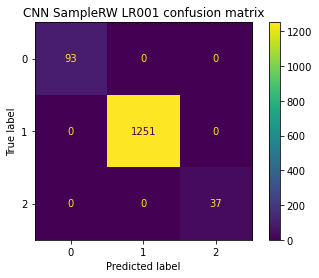

Running CNN SampleRW LR001 Adam


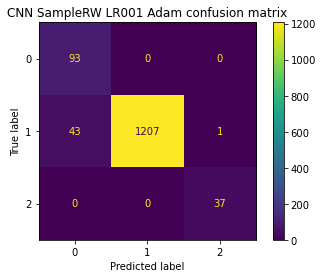

__VAL__
Running CNN SampleRW LR001


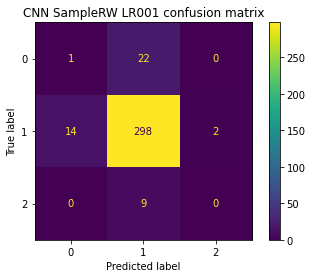

Running CNN SampleRW LR001 Adam


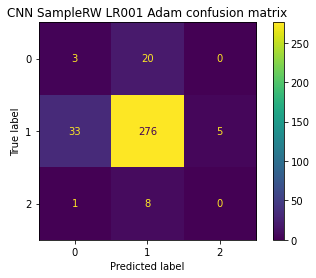

In [79]:
models = [
    ("CNN SampleRW LR001",lr001_cnn,DatasetSpec('ohe')),
    ("CNN SampleRW LR001 Adam",lr001_adam_cnn,DatasetSpec('ohe')),
]

print("__TRAIN__")
dfs_train = plot_confusion(models, train_seqs, oracle,[task])
print("__VAL__")
dfs_val = plot_confusion(models, val_seqs, oracle,[task])

In [80]:
print_cls_rep(dfs_val['CNN SampleRW LR001'][1])
print_cls_rep(dfs_val['CNN SampleRW LR001 Adam'][1])

              precision    recall  f1-score   support

           0       0.07      0.04      0.05        23
           1       0.91      0.95      0.93       314
           2       0.00      0.00      0.00         9

    accuracy                           0.86       346
   macro avg       0.32      0.33      0.33       346
weighted avg       0.83      0.86      0.84       346

              precision    recall  f1-score   support

           0       0.08      0.13      0.10        23
           1       0.91      0.88      0.89       314
           2       0.00      0.00      0.00         9

    accuracy                           0.81       346
   macro avg       0.33      0.34      0.33       346
weighted avg       0.83      0.81      0.82       346



In [82]:
# can I reload teh model checkpoint... here?
lr001_adam_cnn.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

__TRAIN__
Running CNN SampleRW LR001 Adam Reload


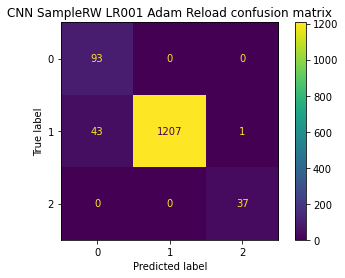

__VAL__
Running CNN SampleRW LR001 Adam Reload


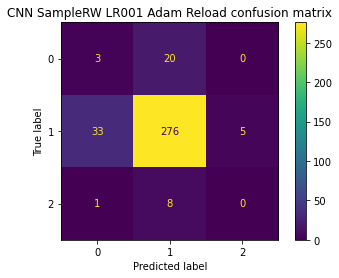

              precision    recall  f1-score   support

           0       0.08      0.13      0.10        23
           1       0.91      0.88      0.89       314
           2       0.00      0.00      0.00         9

    accuracy                           0.81       346
   macro avg       0.33      0.34      0.33       346
weighted avg       0.83      0.81      0.82       346



In [83]:
models = [
    ("CNN SampleRW LR001 Adam Reload",lr001_adam_cnn,DatasetSpec('ohe')),
]

print("__TRAIN__")
dfs_train = plot_confusion(models, train_seqs, oracle,[task])
print("__VAL__")
dfs_val = plot_confusion(models, val_seqs, oracle,[task])

print_cls_rep(dfs_val['CNN SampleRW LR001 Adam Reload'][1])

# getting contrasty

In [ ]:
# from addie's notes

In [97]:
# get 8 classes for positive pairs
con_pos_sets = np.random.choice(range(3),size=8)

# get 8 combos of negative pairs
neg_combos = np.array([(0,1),(0,2),(1,2)])
con_neg_sets_idx = np.random.choice(len(neg_combos),size=8)
con_neg_sets = neg_combos[con_neg_sets_idx]

In [98]:
con_pos_sets

array([0, 2, 0, 0, 1, 1, 1, 0])

In [99]:
con_neg_sets_idx

array([2, 1, 1, 0, 1, 0, 2, 0])

In [100]:
con_neg_sets

array([[1, 2],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 2],
       [0, 1],
       [1, 2],
       [0, 1]])

### slow learning rate and more filters

In [ ]:
# make model
seq_len = len(train_df['upstream_region'].values[0])

f128_lr001_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=128,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
f128_lr001_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"

# run model
f128_lr001_train_losses_cnn, \
f128_lr001_test_losses_cnn,\
estop,best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    f128_lr001_cnn, 
    loss_func,
    lr=0.001,
    epochs=10000,
)

f128_lr001_cnn_data_label = [((f128_lr001_train_losses_cnn,f128_lr001_test_losses_cnn),'CNN f128 lr001',estop,best_val)]

# tu.quick_loss_plot(
#     mer8motif_lin_d_data_label+\
#     mer8motif_cnn_data_label+\
#     mer8motif_cnn_rw_data_label+\
#     lr001_cnn_data_label+\
#     f128_lr001_cnn_data_label,
#     loss_type=loss_label
# )
# f128_lr001_cnn

In [49]:
# run this...

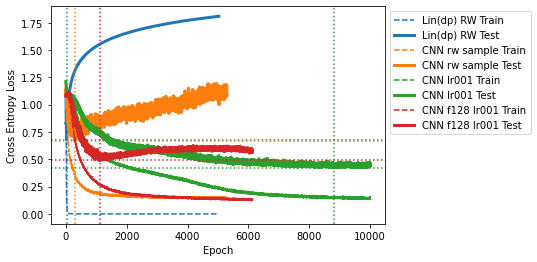

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(128, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2880, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [58]:
tu.quick_loss_plot(
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label+\
    f128_lr001_cnn_data_label,
    loss_type=loss_label
)
f128_lr001_cnn

In [ ]:
# more filters, 0.01 lr
seq_len = len(train_df['upstream_region'].values[0])

f128_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=128,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
f128_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"

# run model
f128_train_losses_cnn, \
f128_test_losses_cnn,\
estop,best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    f128_lr001_cnn, 
    loss_func,
    lr=0.01,
    epochs=10000,
)

f128_cnn_data_label = [((f128_train_losses_cnn,f128_test_losses_cnn),'CNN f128',estop,best_val)]

tu.quick_loss_plot(
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label+\
    f128_lr001_cnn_data_label+\
    f128_cnn_data_label,
    loss_type=loss_label
)
# f128_cnn

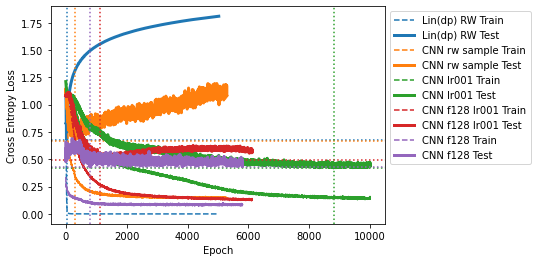

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(128, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2880, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [59]:
tu.quick_loss_plot(
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label+\
    f128_lr001_cnn_data_label+\
    f128_cnn_data_label,
    loss_type=loss_label
)
f128_lr001_cnn

TRAIN
Running LinearDeep RW


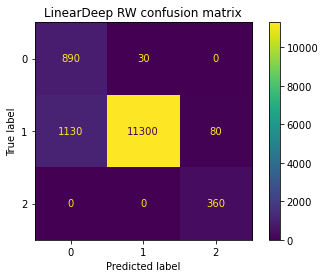

Running CNN RW


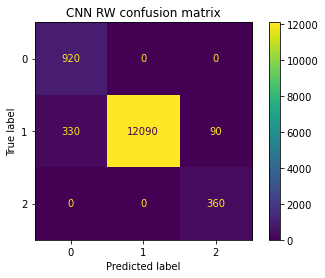

Running CNN lr001


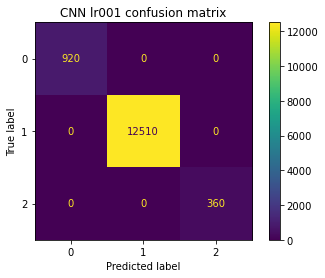

Running CNN f128 lr001


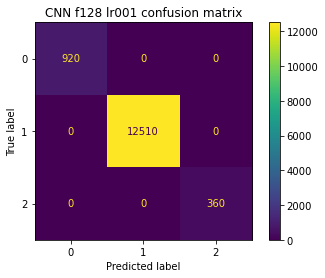

Running CNN f128 


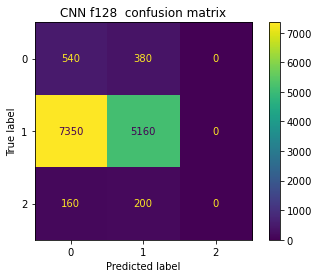


 VAL
Running LinearDeep RW


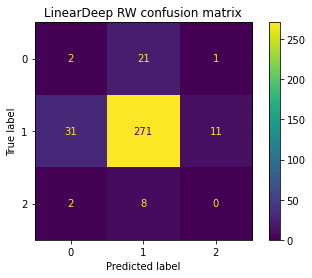

Running CNN RW


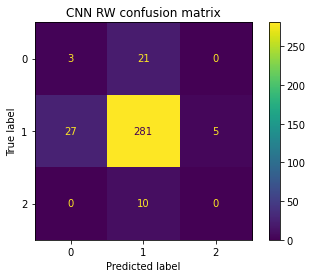

Running CNN lr001


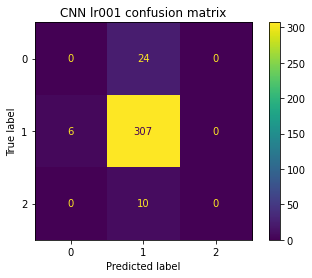

Running CNN f128 lr001


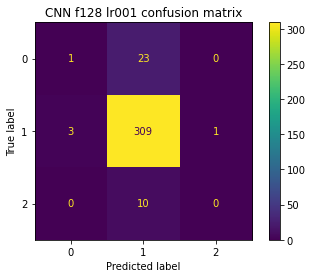

Running CNN f128 


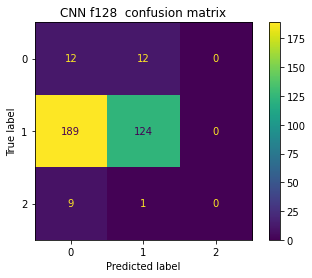

In [60]:
models = [
    ("LinearDeep RW",mer8motif_model_lin_d_rw,DatasetSpec('ohe')),
    ("CNN RW",mer8motif_model_cnn_rw,DatasetSpec('ohe')),
    ("CNN lr001",lr001_cnn,DatasetSpec('ohe')),
    ("CNN f128 lr001",f128_lr001_cnn,DatasetSpec('ohe')),
    ("CNN f128 ",f128_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['locus_tag'].values #val_df['locus_tag'].values #
val_seqs =  val_df['locus_tag'].values #val_df['locus_tag'].values #
#test_seqs =  test_df['locus_tag'].values #val_df['locus_tag'].values #
task = "5G_CuLR_classification"

oracle_reg = dict([(a,[b]) for a,b in XYdf[['locus_tag',reg]].values])

print("TRAIN")
dfs_train = plot_confusion(models, train_seqs, oracle_reg,[task])
print("\n VAL")
dfs_val = plot_confusion(models, val_seqs, oracle_reg,[task])
#dfs_test = plot_confusion(models, test_seqs, oracle_reg,[task])

In [61]:
#cnn_res_rw = dfs_val['CNN'][1]

lind_res_rw = dfs_val['LinearDeep RW'][1]
cnn_res_rw = dfs_val['CNN RW'][1]
cnn_res_lr001 = dfs_val['CNN lr001'][1]
cnn_res_f128_lr001 = dfs_val['CNN f128 lr001'][1]
cnn_res_f128 = dfs_val['CNN f128 '][1]

# cls_report(lind_res,"LinearDeep")
# print()
# cls_report(cnn_res,"CNN")
# print()

cls_report(lind_res_rw,"LinearDeep RW")
print()
cls_report(cnn_res_rw,"CNN RW")
print()
cls_report(cnn_res_lr001,"CNN lr001")
print()
cls_report(cnn_res_f128_lr001,"CNN f128 lr001")
print()
cls_report(cnn_res_f128,"CNN f128 ")

LinearDeep RW (acc=0.787 | mcc=-0.005)
micro: p=0.787	 r=0.787	 f1=0.787
macro: p=0.320	 r=0.316	 f1=0.317

CNN RW (acc=0.818 | mcc=0.006)
micro: p=0.818	 r=0.818	 f1=0.818
macro: p=0.334	 r=0.341	 f1=0.337

CNN lr001 (acc=0.885 | mcc=-0.037)
micro: p=0.885	 r=0.885	 f1=0.885
macro: p=0.300	 r=0.327	 f1=0.313

CNN f128 lr001 (acc=0.893 | mcc=0.048)
micro: p=0.893	 r=0.893	 f1=0.893
macro: p=0.385	 r=0.343	 f1=0.338

CNN f128  (acc=0.392 | mcc=-0.021)
micro: p=0.392	 r=0.392	 f1=0.392
macro: p=0.321	 r=0.299	 f1=0.218


In [65]:
torch.save(mer8motif_model_lin_d_rw.state_dict(),"pat5000/LinearDeep_RW_sd.pth")
torch.save(mer8motif_model_cnn_rw.state_dict(),"pat5000/CNN_RW_sd.pth")
torch.save(lr001_cnn.state_dict(),"pat5000/CNN_lr001_sd.pth")
torch.save(f128_lr001_cnn.state_dict(),"pat5000/CNN_f128_lr001_sd.pth")
torch.save(f128_cnn.state_dict(),"pat5000/CNN_f128_sd.pth")

In [ ]:
# CHECK THIS

In [83]:
aaa = torch.load("pipe0/Kmer3_lr0.01_defaultSampler_no_aug.pth")
bbb = torch.load("pipe0/CNN32_lr0.01_defaultSampler_no_aug.pth")

In [73]:
reload_models = [
    ("kmer3",aaa,DatasetSpec('ohe'))
]
plot_confusion(reload_models, train_seqs, oracle_reg,[task])

Running kmer3


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [74]:
aaa

Kmer_Linear(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [100]:
dna = loc2seq[train_seqs[0]]
seq_ohe = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
seq_kmer = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(3))).unsqueeze(0).to(DEVICE)

In [101]:
seq_ohe.shape

torch.Size([1, 300, 4])

In [102]:
seq_kmer.shape

torch.Size([1, 64])

In [103]:
aaa(seq_kmer.float())

tensor([[ 0.2514,  2.5319, -1.5184]], device='cuda:0', grad_fn=<AddmmBackward>)

In [104]:
bbb(seq_ohe.float())

tensor([[ 0.1733,  2.7443, -0.6653]], device='cuda:0', grad_fn=<AddmmBackward>)

In [105]:
def get_confusion_data(model, model_name, ds, genes, oracle,loc2seq,device):
    '''
    Given a trained model and set of genes, evaluate the model's
    ability to predict these genes' reg class
    '''
    model.eval()
    data = []
    for gene in genes:
        dna = loc2seq[gene]
        if ds.name == 'ohe':
            s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(device)
        elif ds.name == 'kmer':
            s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).unsqueeze(0).to(device)
            # need unsqueeze?
        else:
            raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

        actual = oracle[gene]
        preds = [x.topk(1) for x in model(s.float())]
        print(len(preds))
        print()
        
        for i in range(len(preds)):
            print(i, preds[i])
            prob,clss = [x.item() for x in preds[i]]
            data.append((gene,actual[i], clss,prob,dna))
            
    df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','seq'])
    return df

In [106]:
get_confusion_data(aaa, "dummy", DatasetSpec('kmer',k=3), train_seqs, oracle_reg,loc2seq,DEVICE)

1

0 torch.return_types.topk(
values=tensor([2.5319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1512], device='

0 torch.return_types.topk(
values=tensor([2.4638], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4638], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4638], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4638], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5995], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5995], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5995], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5995], device='cud

1

0 torch.return_types.topk(
values=tensor([1.8784], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8784], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8784], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8784], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8784], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4371], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4371], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4371], device='

0 torch.return_types.topk(
values=tensor([1.8468], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8468], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8468], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8468], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8468], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9676], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9676], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9676], device='cud

0 torch.return_types.topk(
values=tensor([2.6555], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6555], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6555], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6555], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4276], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4276], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4276], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4276], device='cud

1

0 torch.return_types.topk(
values=tensor([2.7392], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7392], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7392], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4600], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4600], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4600], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4600], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4600], device='

0 torch.return_types.topk(
values=tensor([2.5849], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5849], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5849], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5849], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3816], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3816], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3816], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3816], device='cud

1

0 torch.return_types.topk(
values=tensor([3.0263], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0263], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0263], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0263], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3057], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3057], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3057], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3057], device='

1

0 torch.return_types.topk(
values=tensor([2.3421], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3421], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3421], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3421], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0403], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0403], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0403], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0403], device='

1

0 torch.return_types.topk(
values=tensor([2.3185], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3185], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3185], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3185], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1388], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1388], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1388], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1388], device='

0 torch.return_types.topk(
values=tensor([3.1191], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1191], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1191], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1191], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0980], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0980], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0980], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0980], device='cud

0 torch.return_types.topk(
values=tensor([2.6430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7430], device='cud

1

0 torch.return_types.topk(
values=tensor([2.0754], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0754], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0754], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0754], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9381], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9381], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9381], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9381], device='

0 torch.return_types.topk(
values=tensor([2.8510], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8510], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8510], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8510], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8530], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8530], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8530], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8530], device='cud

0 torch.return_types.topk(
values=tensor([2.3937], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3937], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4136], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4136], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4136], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4136], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4136], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9043], device='cud

0 torch.return_types.topk(
values=tensor([2.8693], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8693], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8693], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8693], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6377], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6377], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6377], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6377], device='cud

1

0 torch.return_types.topk(
values=tensor([2.4675], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0414], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0414], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0414], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0414], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0414], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6224], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6224], device='

1

0 torch.return_types.topk(
values=tensor([2.9512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5538], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5538], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5538], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5538], device='

1

0 torch.return_types.topk(
values=tensor([2.4657], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4657], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4657], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4657], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4657], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7554], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7554], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7554], device='


0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6687], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6687], device='cu

0 torch.return_types.topk(
values=tensor([2.4726], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4726], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4726], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4726], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4726], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1735], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1735], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1735], device='cud

1

0 torch.return_types.topk(
values=tensor([3.2523], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2523], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2523], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5011], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5011], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5011], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5011], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5011], device='

1

0 torch.return_types.topk(
values=tensor([2.7561], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7561], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8472], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8472], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8472], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8472], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8472], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1528], device='

1

0 torch.return_types.topk(
values=tensor([2.9575], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9575], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9575], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9575], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9575], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8012], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8012], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8012], device='

1

0 torch.return_types.topk(
values=tensor([2.0958], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0958], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0958], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2833], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2833], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2833], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2833], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2833], device='

0 torch.return_types.topk(
values=tensor([2.6656], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6656], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6656], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7089], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7089], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7089], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7089], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7089], device='cud

0 torch.return_types.topk(
values=tensor([2.6014], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6014], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6014], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6014], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6014], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7319], device='cud

0 torch.return_types.topk(
values=tensor([3.0159], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0159], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0159], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0159], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1199], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1199], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1199], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1199], device='cud

1

0 torch.return_types.topk(
values=tensor([2.6943], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6943], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6943], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1923], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1923], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1923], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1923], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1923], device='

1

0 torch.return_types.topk(
values=tensor([2.5716], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9940], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9940], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9940], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9940], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9940], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9555], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9555], device='

0 torch.return_types.topk(
values=tensor([2.5829], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5829], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5829], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5829], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6325], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6325], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6325], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6325], device='cud

0 torch.return_types.topk(
values=tensor([3.0128], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0128], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0128], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6764], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6764], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6764], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6764], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6764], device='cud

1

0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7446], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7446], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7446], device='

1

0 torch.return_types.topk(
values=tensor([2.7919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5836], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5836], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5836], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5836], device='

1

0 torch.return_types.topk(
values=tensor([2.9746], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9746], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7890], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7890], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7890], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7890], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7890], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.5410], device='

1

0 torch.return_types.topk(
values=tensor([2.2753], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2753], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2753], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2753], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2753], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7076], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7076], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7076], device='

1

0 torch.return_types.topk(
values=tensor([2.2821], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2821], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1350], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1350], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1350], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1350], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1350], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8310], device='

0 torch.return_types.topk(
values=tensor([1.8482], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8482], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8482], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8482], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8482], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2863], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2863], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2863], device='cud

0 torch.return_types.topk(
values=tensor([2.1537], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1537], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1537], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4508], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4508], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4508], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4508], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4508], device='cud

1

0 torch.return_types.topk(
values=tensor([2.4111], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4111], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4111], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4111], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1268], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1268], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1268], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1268], device='

0 torch.return_types.topk(
values=tensor([2.0722], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0722], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0722], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0722], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5820], device='cud

1

0 torch.return_types.topk(
values=tensor([2.3242], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3242], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.4323], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.4323], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.4323], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.4323], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.4323], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7612], device='

1

0 torch.return_types.topk(
values=tensor([2.5003], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3283], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3283], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3283], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3283], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3283], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.6935], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.6935], device='

1

0 torch.return_types.topk(
values=tensor([2.0591], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9280], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9280], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9280], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9280], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9280], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5960], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5960], device='

1

0 torch.return_types.topk(
values=tensor([2.2349], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2349], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2349], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2349], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5919], device='

KeyboardInterrupt: 

In [ ]:
get_confusion_data(bbb, "dummy", DatasetSpec('ohe'), train_seqs, oracle_reg,loc2seq,DEVICE)


In [ ]:
aaa needs to be kmer

# filter viz

In [73]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    #print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    
#     with tqdm.trange(epochs) as pbar:
#         for i in pbar:
            
    for seq in tqdm.tqdm(seqs):
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8,ysc=1.0):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 20*ysc))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 2


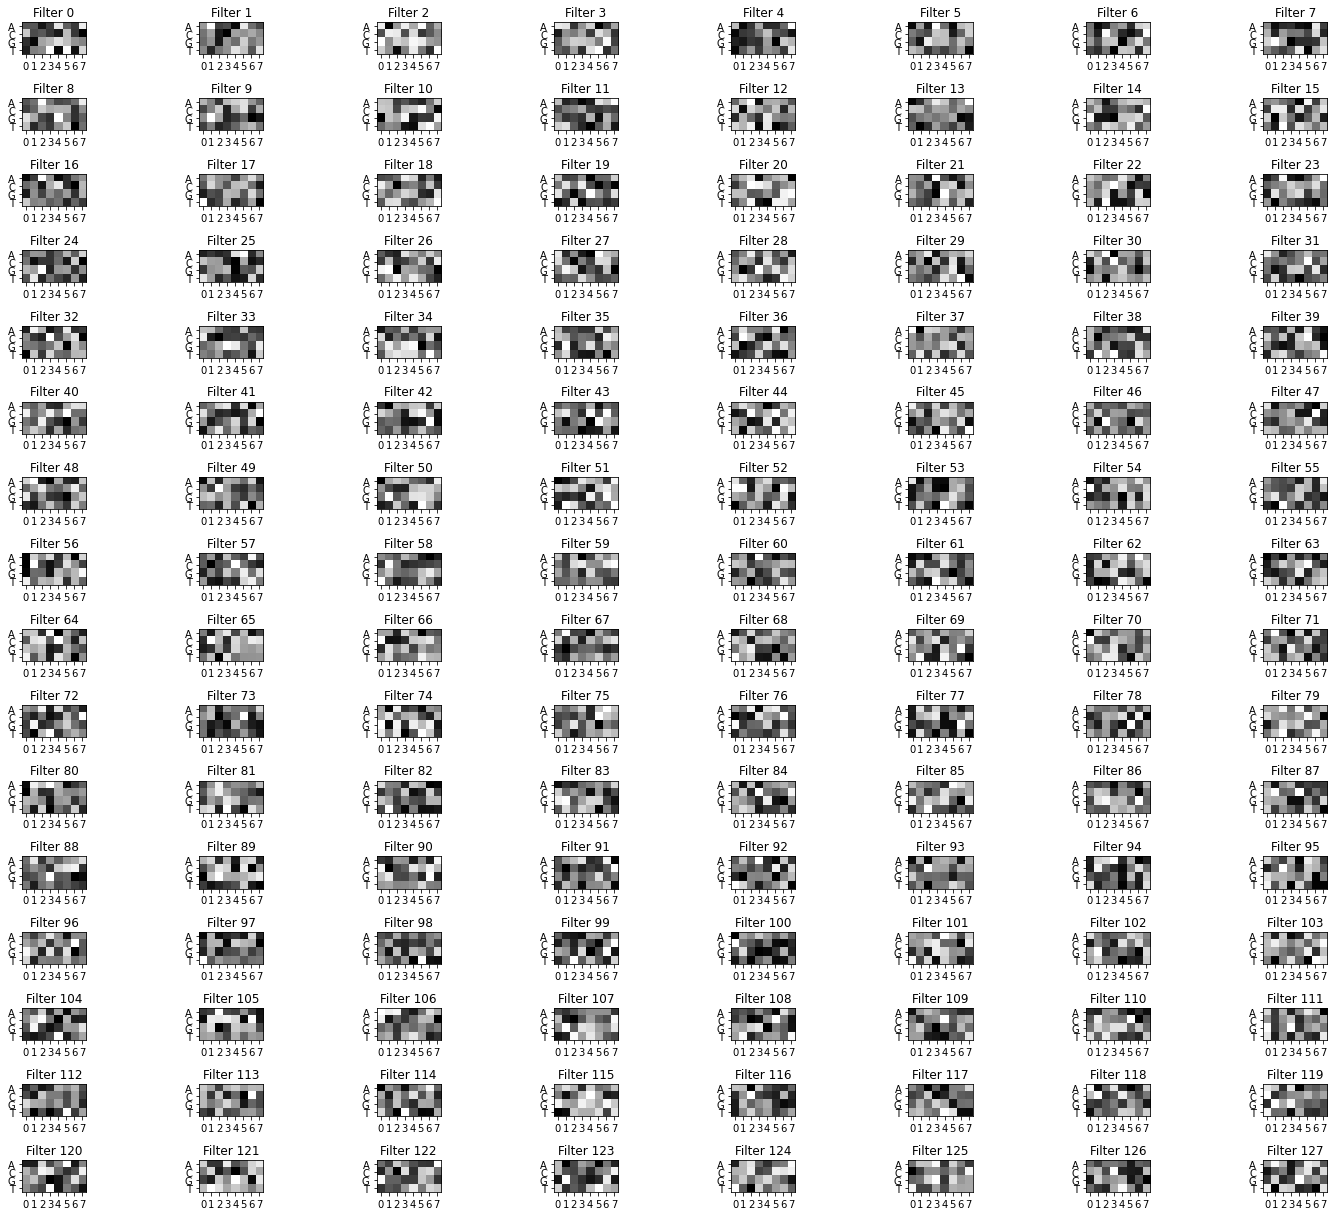

In [74]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(f128_lr001_cnn)
view_filters(model_weights)

In [75]:
seqs = [loc2seq[x] for x in train_df['locus_tag'].values[:500]]

filter_activations = get_filter_activations(seqs, conv_layers[0])

Num filters 128
filt_width 8


100%|██████████| 500/500 [03:45<00:00,  2.21it/s]


torch.Size([128, 4, 8])


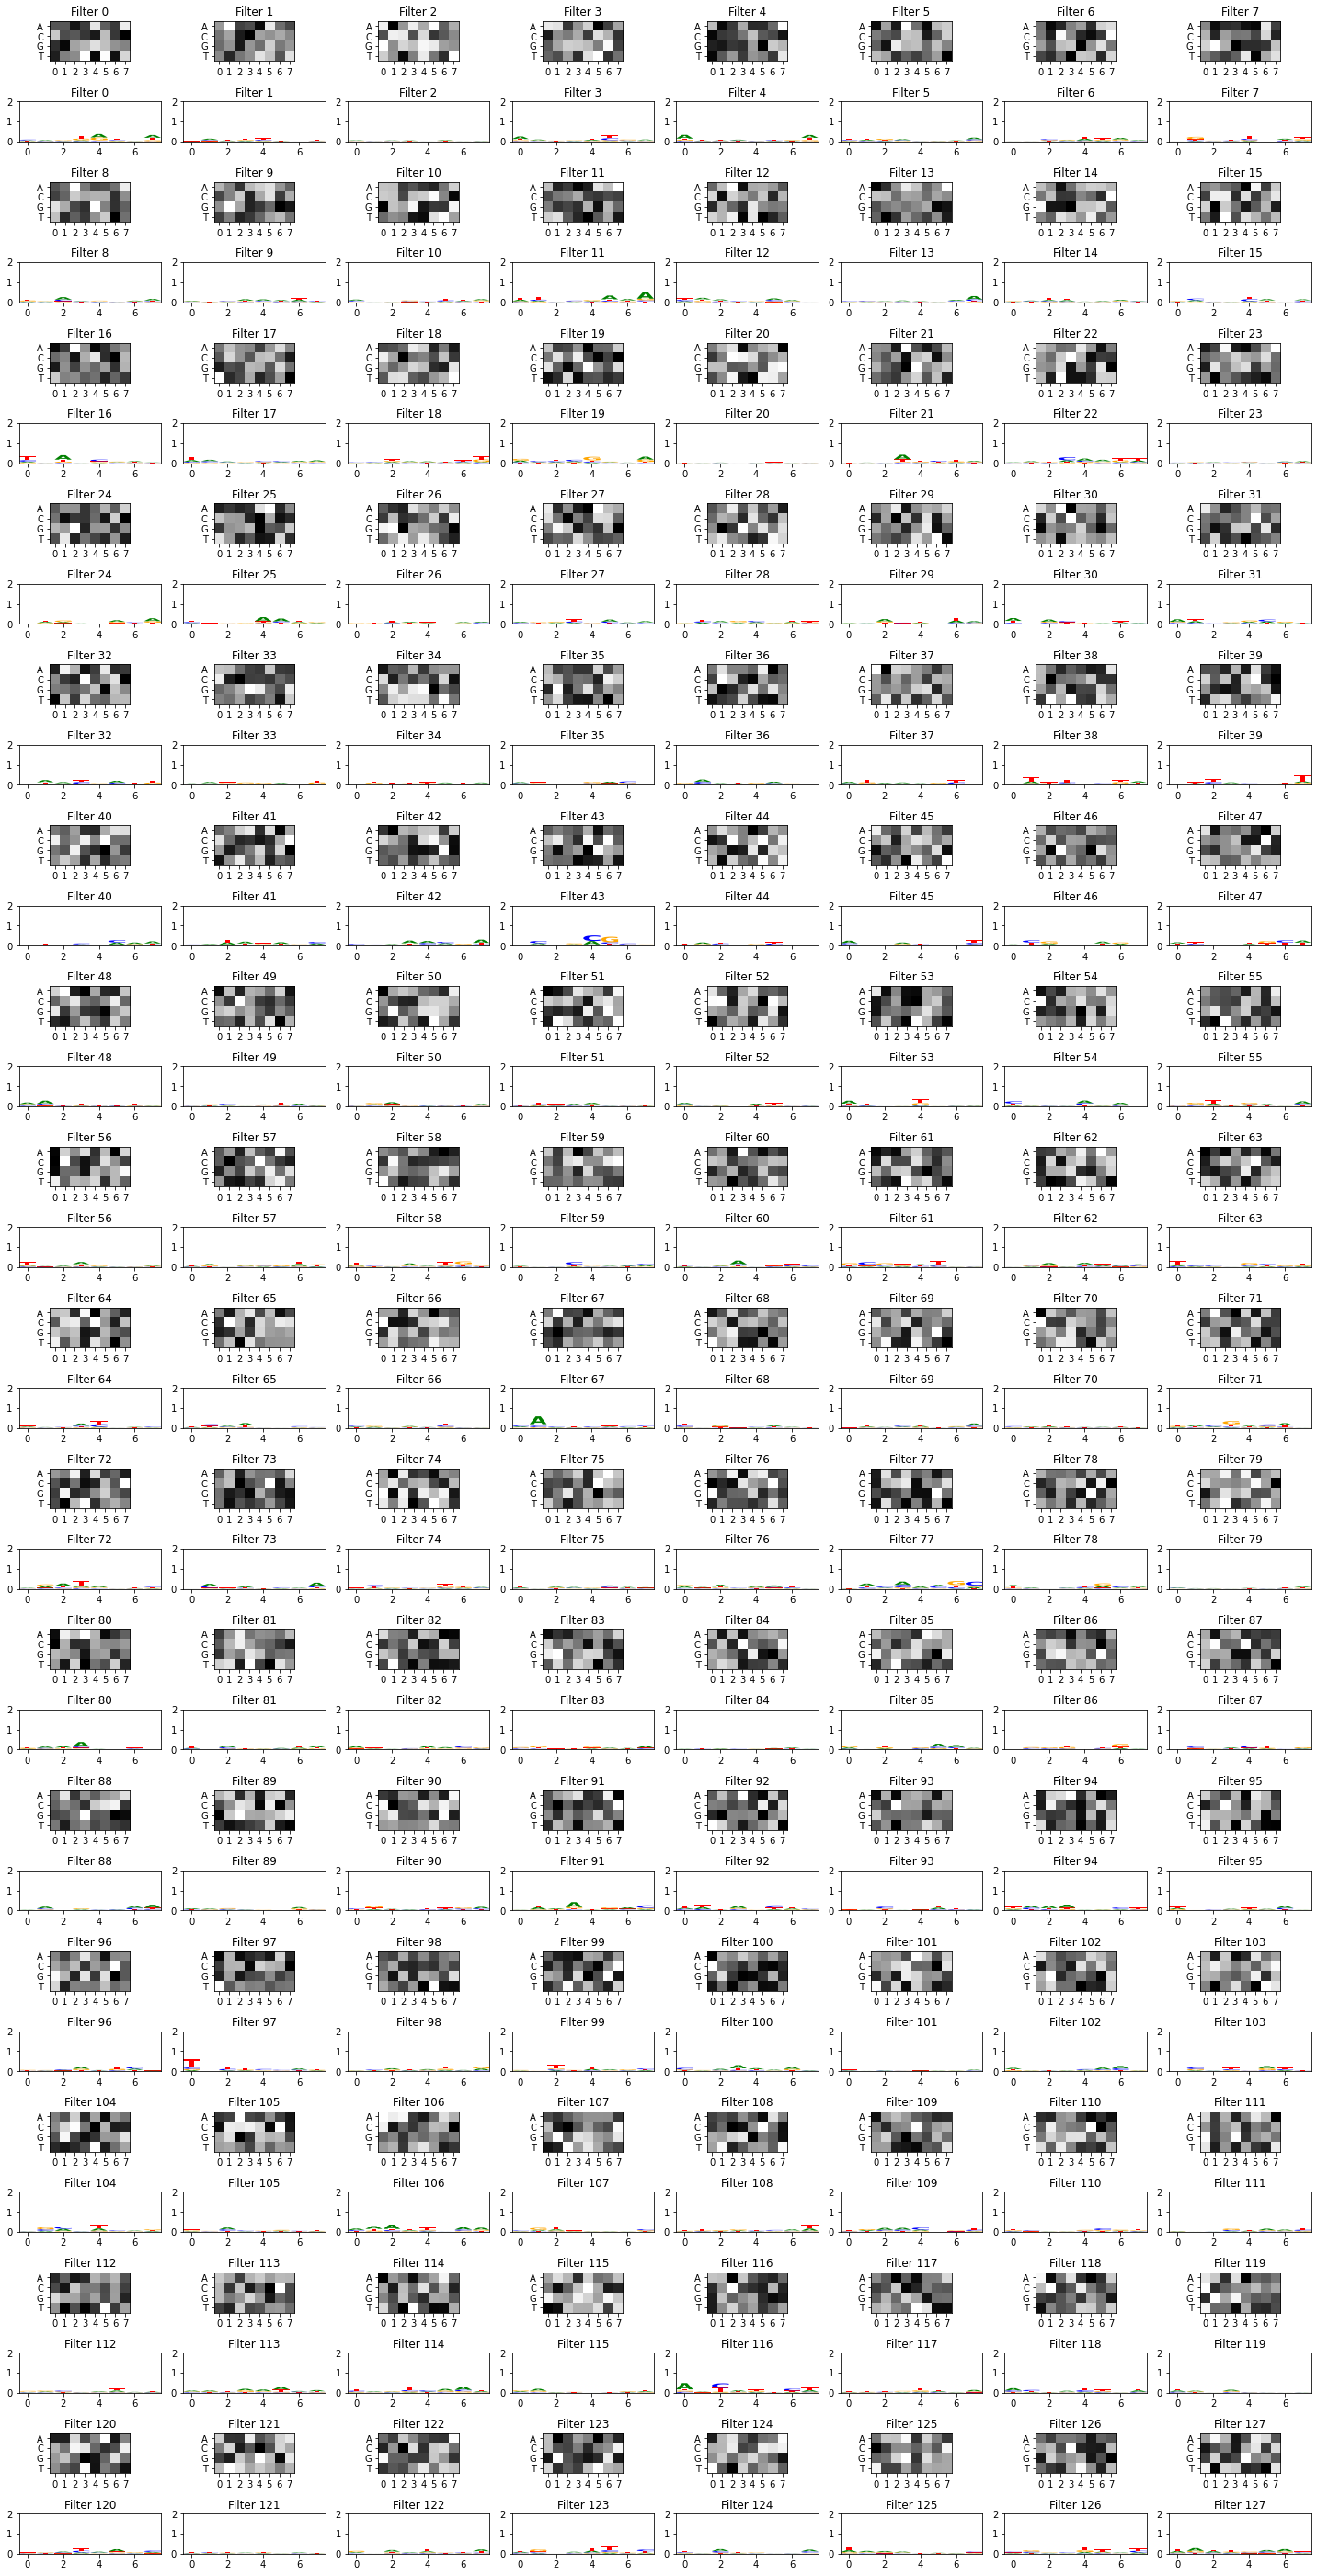

In [76]:
view_filters_and_logos(model_weights,filter_activations,ysc=2)

### some tinkering with KFold CV... maybe come back later

In [50]:
from sklearn.model_selection import StratifiedKFold

In [85]:
cv = StratifiedKFold(5,shuffle=True)

In [115]:
X = np.array(ft)
y = list(np.array(ft['highCu_reg_UD'].values))

trains = []
tests = []
for fold,(train_ids, test_ids) in enumerate(cv.split(X,y)):
    print("fold",fold)
    xtrain = ft.reset_index().iloc[train_ids]
    xtest = ft.reset_index().iloc[test_ids]
    trains.append(xtrain)
    tests.append(xtest)

fold 0
fold 1
fold 2
fold 3
fold 4


In [119]:
for i in range(5):
    traini = trains[i]
    testi = tests[i]
    
    print("fold",i)
    print("TRAIN")
    print(traini['highCu_reg_UD'].value_counts())
    print("TEST")
    print(testi['highCu_reg_UD'].value_counts())
    print()

fold 0
TRAIN
1    1313
0      55
2      12
Name: highCu_reg_UD, dtype: int64
TEST
1    329
0     14
2      2
Name: highCu_reg_UD, dtype: int64

fold 1
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 2
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 3
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 4
TRAIN
1    1313
0      56
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    329
0     13
2      3
Name: highCu_reg_UD, dtype: int64



## Old tinkering

In [46]:
w = torch.tensor([10.0,100.0,1.0])
cel = nn.CrossEntropyLoss()
celw = nn.CrossEntropyLoss(weight=w)

In [48]:
a = torch.tensor([[1.0,2.0,3.0],
                  [1.0,3.0,2.0],
                  [3.0,1.0,2.0]])

b = torch.tensor([2,1,2])
c = torch.tensor([0,1,2])

print('normal')
print(cel(a,b))
print(cel(a,c))
print()
print('weighted')
print(celw(a,b))
print(celw(a,c))

normal
tensor(0.7409)
tensor(1.4076)

weighted
tensor(0.4174)
tensor(0.5968)


In [45]:
print(a.shape)
print(b.shape)

torch.Size([2, 3])
torch.Size([2])


In [104]:
seqs = train_df['locus_tag'].values #val_df['locus_tag'].values

p = quick_classify(mer8motif_model_cnn,seqs,oracle_syn)

EQU24_RS06320: pred:2 actual:0
EQU24_RS06320: pred:2 actual:0 ([6.231020450592041, -6.871827602386475, 6.793558597564697])
EQU24_RS06855: pred:1 actual:0
EQU24_RS06855: pred:1 actual:0 ([5.818170547485352, 6.306614875793457, -5.028451919555664])
EQU24_RS16240: pred:1 actual:0
EQU24_RS16240: pred:1 actual:0 ([6.875643253326416, 7.228374004364014, -6.141620635986328])


In [93]:
p.tolist()[0]

[6.06266975402832, 2.4189703464508057, -2.8052988052368164]

In [67]:
genes = train_df['locus_tag'].values
seqs = [torch.tensor(u.one_hot_encode(loc2seq[x])).unsqueeze(0).to(DEVICE).float() for x in genes]

preds = mer8motif_model_cnn(torch.stack(seqs).squeeze(1))

In [85]:
preds

tensor([[9.9989e-01, 1.0368e-04, 8.5303e-06],
        [9.9997e-01, 2.7287e-05, 2.8173e-06],
        [9.8730e-01, 5.0449e-05, 1.2647e-02],
        ...,
        [9.9740e-01, 1.9590e-05, 2.5840e-03],
        [9.9967e-01, 2.5071e-04, 8.1230e-05],
        [9.9950e-01, 4.3107e-04, 6.7942e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [85]:
val_df.value_counts('reg')

reg
0    334
2     11
1      8
dtype: int64

In [110]:
genes_with_motifs = ['EQU24_RS00275','EQU24_RS01000','EQU24_RS01145','EQU24_RS01350','EQU24_RS01510','EQU24_RS01840','EQU24_RS01895','EQU24_RS01900','EQU24_RS02065','EQU24_RS02090','EQU24_RS02305','EQU24_RS02735','EQU24_RS02990','EQU24_RS03550','EQU24_RS03555','EQU24_RS03610','EQU24_RS04575','EQU24_RS04690','EQU24_RS05030','EQU24_RS05090','EQU24_RS05095','EQU24_RS05810','EQU24_RS05885','EQU24_RS06285','EQU24_RS06410','EQU24_RS06960','EQU24_RS07465','EQU24_RS07825','EQU24_RS08030','EQU24_RS08830','EQU24_RS08840','EQU24_RS08860','EQU24_RS08880','EQU24_RS09300','EQU24_RS09730','EQU24_RS09760','EQU24_RS09900','EQU24_RS10145','EQU24_RS10685','EQU24_RS10700','EQU24_RS10745','EQU24_RS12075','EQU24_RS12370','EQU24_RS12810','EQU24_RS13170','EQU24_RS13370','EQU24_RS13465','EQU24_RS14795','EQU24_RS14835','EQU24_RS15280','EQU24_RS15800','EQU24_RS15850','EQU24_RS16395','EQU24_RS16400','EQU24_RS16545','EQU24_RS16935','EQU24_RS17340','EQU24_RS17960','EQU24_RS18175','EQU24_RS18350','EQU24_RS18600','EQU24_RS18860','EQU24_RS19095','EQU24_RS19160','EQU24_RS19290','EQU24_RS19580','EQU24_RS20100','EQU24_RS20210','EQU24_RS20225','EQU24_RS20485','EQU24_RS20940','EQU24_RS21145','EQU24_RS21675','EQU24_RS21805','EQU24_RS21815']
seqs_with_motifs = [loc2seq[x] for x in genes_with_motifs]
seqs_with_motifs = [torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).to(DEVICE).float() for seq in seqs_with_motifs]
preds = mer8motif_model_cnn(torch.stack(seqs_with_motifs).squeeze(1))

In [113]:
quick_classify(mer8motif_model_cnn,genes_with_motifs,oracle_syn)

done
